In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import folium
import plotly.express as px
import json
import numpy as np
from sklearn.neighbors import BallTree
import folium
from sklearn.metrics.pairwise import haversine_distances

In [2]:
# macOS 기본 한글 폰트 설정 (AppleSDGothicNeo 등)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [3]:
path = '/Users/yniyunj/Desktop/교육공공데이터/데이터/002-전출입생수/'

df_24 = pd.read_csv(path + '2024년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_23 = pd.read_csv(path + '2023년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_22 = pd.read_csv(path + '2022년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_21 = pd.read_csv(path + '2021년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_20 = pd.read_csv(path + '2020년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_19 = pd.read_csv(path + '2019년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_18 = pd.read_csv(path + '2018년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_17 = pd.read_csv(path + '2017년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_16 = pd.read_csv(path + '2016년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df_15 = pd.read_csv(path + '2015년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')

# 데이터 전처리

- 2025년도의 각 학교 SCR index 값은??

## 1.1 해당 학교 학생수 감소율 ($S_i$)

- 3년간 연평균 학생수 감소율의 평균
- 단기적으로 학교 규모 축소의 빠르기를 계산   

- $S_i = \frac{1}{3} \sum_{k=1}^3 \frac{총학생수_{k년전} - 총학생수_{k-1년전}}{총학생수_{k년전}}$

In [4]:
df_21.columns

Index(['시도교육청', '교육지원청', '지역', '정보공시 학교코드', '학교명', '학교급코드', '설립구분', '제외여부',
       '제외사유', '1학년 전입학생수', '1학년 전출학생수', '1학년 전체학생수', '2학년 전입학생수', '2학년 전출학생수',
       '2학년 전체학생수', '3학년 전입학생수', '3학년 전출학생수', '3학년 전체학생수', '4학년 전입학생수',
       '4학년 전출학생수', '4학년 전체학생수', '5학년 전입학생수', '5학년 전출학생수', '5학년 전체학생수',
       '6학년 전입학생수', '6학년 전출학생수', '6학년 전체 학생수', '전입학생수(계)', '전출학생수(계)',
       '전체학생수(계)'],
      dtype='object')

In [5]:
# 1. 연도별 필요한 컬럼 추출 (학교코드 + 총학생수만)
df_21_1 = df_21[['정보공시 학교코드', '전체학생수(계)']].rename(columns={'전체학생수(계)': 'student_2021'})
df_22_1 = df_22[['정보공시 학교코드', '전체학생수(계)']].rename(columns={'전체학생수(계)': 'student_2022'})
df_23_1 = df_23[['정보공시 학교코드', '전체학생수(계)']].rename(columns={'전체학생수(계)': 'student_2023'})
df_24_1 = df_24[['정보공시 학교코드', '전체학생수(계)']].rename(columns={'전체학생수(계)': 'student_2024'})

# 2. 병합 (학교코드 기준)
df_merge_1 = df_21_1.merge(df_22_1, on='정보공시 학교코드', how='inner') \
                  .merge(df_23_1, on='정보공시 학교코드', how='inner') \
                  .merge(df_24_1, on='정보공시 학교코드', how='inner')

# 3. S_i 계산 (결측치 제외하고 평균)
def calculate_S_i(row):
    ratios = []

    # student_2021 → student_2022
    if pd.notnull(row['student_2021']) and pd.notnull(row['student_2022']) and row['student_2021'] != 0:
        ratios.append((row['student_2021'] - row['student_2022']) / row['student_2021'])

    # student_2022 → student_2023
    if pd.notnull(row['student_2022']) and pd.notnull(row['student_2023']) and row['student_2022'] != 0:
        ratios.append((row['student_2022'] - row['student_2023']) / row['student_2022'])

    # student_2023 → student_2024
    if pd.notnull(row['student_2023']) and pd.notnull(row['student_2024']) and row['student_2023'] != 0:
        ratios.append((row['student_2023'] - row['student_2024']) / row['student_2023'])

    if ratios:
        return sum(ratios) / len(ratios)
    else:
        return np.nan

df_merge_1['S_i(2025)'] = df_merge_1.apply(calculate_S_i, axis=1)

# 4. 결과 추출
df_result_1 = df_merge_1[['정보공시 학교코드', 'S_i(2025)']]

df_result_1 = df_result_1.merge(df_24[['정보공시 학교코드', '학교명', '지역']], on='정보공시 학교코드', how='left')
df_result_1 = df_result_1[['정보공시 학교코드', '지역', '학교명', 'S_i(2025)']]
df_result_1 = df_result_1[df_result_1['지역'].fillna('').str.startswith('충청북도')]

df_result_1 = df_result_1[['지역', '학교명', 'S_i(2025)']].copy()
df_result_1['지역'] = df_result_1['지역'].apply(lambda x: ' '.join(str(x).split()[:2]))
df_result_1.to_csv(path+'/SCR_data/1-S_i(2025).csv', index=False)
df_result_1

,지역,학교명,S_i(2025)
3571,충청북도 청주시,청주교육대학교부설초등학교,0.030908
3572,충청북도 청주시,한국교원대학교부설월곡초등학교,0.057903
3573,충청북도 괴산군,감물초등학교,-0.057043
3574,충청북도 괴산군,괴산명덕초등학교,0.121450
3575,충청북도 증평군,도안초등학교,-0.190013
...,...,...,...
3830,충청북도 충주시,충주중앙탑초등학교,-0.066565
3831,충청북도 청주시,생명초등학교,-0.180814
3832,충청북도 충주시,충주대소원초등학교,-0.105675
3833,충청북도 충주시,충주남한강초등학교,-0.100296


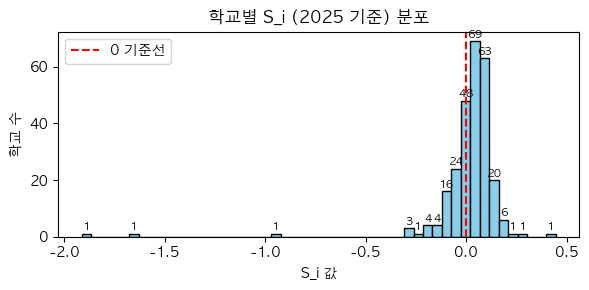

In [6]:
# inf, -inf, NaN 제거
data = df_result_1['S_i(2025)'].replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(6, 3))

# 히스토그램 그리기
counts, bin_edges, patches = plt.hist(
    data, 
    bins=50, 
    color='skyblue', 
    edgecolor='black'
)

# 0 기준선
plt.axvline(0, color='red', linestyle='--', label='0 기준선')

# 각 막대 위에 숫자 표시
for count, x in zip(counts, bin_edges[:-1]):
    if count > 0:
        plt.text(
            x + (bin_edges[1] - bin_edges[0])/2,
            count + 0.5,
            int(count),
            ha='center', va='bottom', fontsize=8
        )

plt.title("학교별 S_i (2025 기준) 분포")
plt.xlabel("S_i 값")
plt.ylabel("학교 수")
plt.legend()
plt.tight_layout()
plt.show()

## 1.2 해당 학교 전출입 증가율 ($T_i$)

- 3년간 연평균 전출 증가율의 평균
- 학생들이 해당 학교를 떠나는 흐름이 가속화되는지 계산   

- $T_i = \frac{1}{3} \sum_{k=1}^3 \frac{전출수_{k년전} - 전입수_{k년전}}{총학생수_{k년전}}$

In [7]:
# 필요한 열만 추출
cols = ['정보공시 학교코드', '지역', '학교명', '전입학생수(계)', '전출학생수(계)', '전체학생수(계)']

# 필요한 연도 데이터 정제
df_22_2 = df_22[cols].copy()
df_23_2 = df_23[cols].copy()
df_24_2 = df_24[cols].copy()

# 연도 정보 추가
df_22_2['year'] = 2022
df_23_2['year'] = 2023
df_24_2['year'] = 2024

# 통합
df_all = pd.concat([df_22_2, df_23_2, df_24_2])

# 계산식: (전출 - 전입) / 전체학생수
# 전체학생수(계)가 0이면 결과를 0으로 설정
T_i_values = []
for idx, row in df_all.iterrows():
    if row['전체학생수(계)'] == 0:
        T_i_values.append(0)
    else:
        T_i_values.append((row['전출학생수(계)'] - row['전입학생수(계)']) / row['전체학생수(계)'])

# ✅ 결과를 새로운 열로 추가
df_all['T_i (2025)'] = T_i_values

# 학교별 평균 계산
df_result_2 = df_all.groupby(['정보공시 학교코드', '지역', '학교명'])['T_i (2025)'].mean().reset_index()
df_result_2 = df_result_2[df_result_2['지역'].fillna('').str.startswith('충청북도')]

df_result_2 = df_result_2[['지역', '학교명', 'T_i (2025)']].copy()
df_result_2['지역'] = df_result_2['지역'].apply(lambda x: ' '.join(str(x).split()[:2]))
df_result_2.to_csv(path+'/SCR_data/2-T_i(2025).csv', index=False)
df_result_2

,지역,학교명,T_i (2025)
9,충청북도 청주시,청주교육대학교부설초등학교,0.006705
10,충청북도 청주시,한국교원대학교부설월곡초등학교,0.006550
3645,충청북도 괴산군,감물초등학교,-0.061153
3646,충청북도 괴산군,괴산명덕초등학교,0.040922
3647,충청북도 증평군,도안초등학교,-0.005400
...,...,...,...
3906,충청북도 충주시,충주남한강초등학교,-0.022180
3907,충청북도 청주시,용아초등학교,-0.099035
3908,충청북도 충주시,용원초등학교동락분교장,0.166667
3909,충청북도 단양군,영춘초등학교별방분교장,0.122222


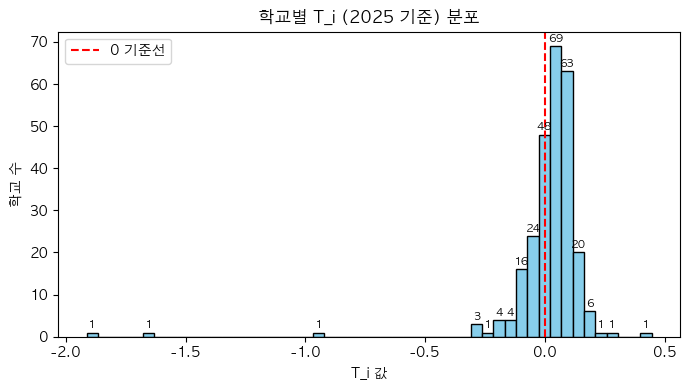

In [8]:
plt.figure(figsize=(7, 4))

# 히스토그램 그리기
counts, bin_edges, patches = plt.hist(
    data, 
    bins=50, 
    color='skyblue', 
    edgecolor='black'
)

# 0 기준선
plt.axvline(0, color='red', linestyle='--', label='0 기준선')

# 각 막대 위에 숫자 표시
for count, x in zip(counts, bin_edges[:-1]):
    if count > 0:
        plt.text(
            x + (bin_edges[1] - bin_edges[0])/2,
            count + 0.5,
            int(count),
            ha='center', va='bottom', fontsize=8
        )

plt.title("학교별 T_i (2025 기준) 분포")
plt.xlabel("T_i 값")
plt.ylabel("학교 수")
plt.legend()
plt.tight_layout()
plt.show()

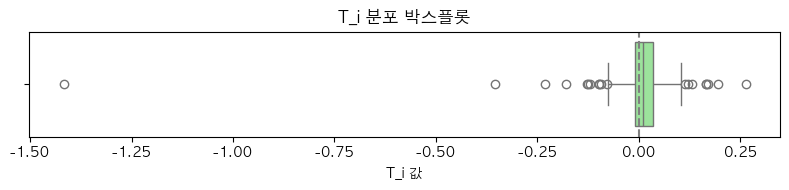

In [9]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=df_result_2['T_i (2025)'], color='lightgreen')
plt.axvline(0, color='gray', linestyle='--')
plt.title("T_i 분포 박스플롯")
plt.xlabel("T_i 값")
plt.tight_layout()
plt.show()

## 1.3 해당 통학구역 신생아수 감소율 ($B_i$)

- 7년간 연평균 신생아수 감소율의 평균 (2020~ 데이터만 존재해서 총 5년(2020-2024) 데이터 사용함)
- 해당 지역의 미래 학령인구 기반이 약화되고 있는 정도   

- $B_i = \frac{1}{7} \sum_{k=1}^7 \frac{신생아수_{k년전} - 신생아수_{k-1년전}}{신생아수_{k년전}}$

In [10]:
df_baby = pd.read_csv(path + '장래_인구변동요인_출생__사망__인구이동_등__20250426125222.csv')
df_baby

,행정구역별(1),2020,2020.1,2020.2,2021,2021.1,2021.2,2022,2022.1,2022.2,2023,2023.1,2023.2,2024,2024.1,2024.2
0,행정구역별(1),인구(명),출생아수(명),조출생률(인구천명당),인구(명),출생아수(명),조출생률(인구천명당),인구(명),출생아수(명),조출생률(인구천명당),인구(명),출생아수(명),조출생률(인구천명당),인구(명),출생아수(명),조출생률(인구천명당)
1,충청북도,1630839,8952,5.5,1632358,8683,5.3,1633687,8375,5.1,1635672,7994,4.9,1637564,8022,4.9
2,청주시,855530,5379,6.3,859652,5319,6.2,861345,5171,6.0,864352,4962,5.7,866741,5000,5.8
3,충주시,216776,1104,5.1,216608,1010,4.7,215972,933,4.3,215787,891,4.1,215637,896,4.2
4,제천시,134741,614,4.6,133885,568,4.2,133755,518,3.9,133210,492,3.7,132610,492,3.7
5,보은군,31666,95,3.0,31369,81,2.6,31179,84,2.7,31016,77,2.5,30926,74,2.4
6,옥천군,48985,168,3.4,48671,145,3.0,48452,127,2.6,48471,118,2.4,48514,115,2.4
7,영동군,47171,195,4.1,46114,152,3.3,45397,132,2.9,44808,121,2.7,44415,119,2.7
8,증평군,37298,205,5.5,36720,225,6.1,37353,251,6.7,37739,243,6.4,37991,245,6.4
9,진천군,89694,596,6.6,92721,590,6.4,93826,575,6.1,94775,548,5.8,95828,550,5.7


In [11]:
# ✅ 필요한 컬럼만 선택
cols = ['행정구역별(1)', '2020.2', '2021.2', '2022.2', '2023.2', '2024.2']
df_selected = df_baby[cols]
df_selected = df_selected.iloc[1:].reset_index(drop=True)

for col in ['2020.2', '2021.2', '2022.2', '2023.2', '2024.2']:
    df_selected[col] = pd.to_numeric(df_selected[col], errors='coerce')

df_selected['B_i(2025)'] = df_selected[['2020.2', '2021.2', '2022.2', '2023.2', '2024.2']].mean(axis=1).round(2)
df_result_3 = df_selected.rename(columns={'행정구역별(1)': '행정구역'})

df_result_3 = df_result_3[['행정구역', 'B_i(2025)']]
df_result_3

,행정구역,B_i(2025)
0,충청북도,5.14
1,청주시,6.00
2,충주시,4.48
3,제천시,4.02
4,보은군,2.64
5,옥천군,2.76
6,영동군,3.14
7,증평군,6.22
8,진천군,6.12
9,괴산군,1.88


In [12]:
df_result_3.to_csv(path + 'SCR_data/3-B_i(2025).csv')

## 1.4 인접학교 밀집도 ($D_i$)

- 폐교해도 대체가 가능한지 보여주는 지표
- 밀집도가 높을수록 전출 가능성↑, 폐교 용이성↑   

- $D_i = 반경 R km 이내의 초등학교 수$

In [13]:
df_24_schools = pd.read_csv(path + '250425-충청북도_학교별_주소_new위도_new경도.csv')
df_24_schools

,Unnamed: 0,학교명,학교도로명 주소,폐교여부,new위도,new경도
0,0,청주교육대학교부설초등학교,충청북도 청주시 서원구 청남로 2067,N,36.617245,127.484741
1,1,한국교원대학교부설월곡초등학교,충청북도 청주시 흥덕구 강내면 가로수로 562,N,36.622385,127.362822
2,2,감물초등학교,충청북도 괴산군 감물면 남양동길 38,N,36.839123,127.871318
3,3,괴산명덕초등학교,충청북도 괴산군 괴산읍 읍내로4길 53,N,36.809356,127.787067
4,4,도안초등학교,충청북도 증평군 도안면 화성로 101,N,36.817063,127.611156
...,...,...,...,...,...,...
292,292,충주남한강초등학교,충청북도 충주시 호암수청2로 55,N,36.955144,127.929240
293,293,용아초등학교,충청북도 청주시 상당구 중고개로142번길 32-15,N,36.618252,127.522719
294,294,용원초등학교동락분교장,충청북도 충주시 신니면 신덕로 301,N,37.003450,127.686138
295,295,영춘초등학교별방분교장,충청북도 단양군 영춘면 별방창원로 449,N,37.096357,128.415812


### 가장 가까운 학교 간 평균거리 계산

- 폐교된 학교를 제외한 학교들
- 가장 가까운 학교 간 평균거리 계산
- 행정구역 단위로 계산 (행정구역 간의 편차가 크기 때문)

In [14]:
# 1. 운영 중인 학교만 필터링
df_active = df_24_schools[df_24_schools['폐교여부'] == 'N'].reset_index(drop=True)

# 2. '행정구역' 컬럼 생성 (학교도로명 주소를 스페이스로 분리 → 두 번째 단어)
df_active['행정구역'] = df_active['학교도로명 주소'].apply(lambda x: str(x).split()[1] if pd.notnull(x) else np.nan)
df_active['행정구역'] = df_active['행정구역'].replace('청원군', '청주시')

# 3. 결과 저장용
results = []

# 4. 행정구역별로 평균 계산
for area, group in df_active.groupby('행정구역'):
    coords = np.radians(group[['new위도', 'new경도']].values)

    if len(coords) <= 1:
        # 학교가 1개뿐이면 거리 계산 불가 (NaN 처리)
        mean_nearest_distance = np.nan
    else:
        dist_matrix = haversine_distances(coords) * 6371  # km 단위
        np.fill_diagonal(dist_matrix, np.inf)  # 자기 자신 제외
        min_distances = dist_matrix.min(axis=1)
        mean_nearest_distance = np.median(min_distances)  # ✅ 여기만 mean → median

    results.append({
        '행정구역': area,
        '운영 중인 학교 수': len(group),
        '평균 가장 가까운 거리 (km)': round(mean_nearest_distance, 2)
    })

# 5. 결과 DataFrame
df_nearest_distance = pd.DataFrame(results)

# 결과 출력
print(df_nearest_distance)

   행정구역  운영 중인 학교 수  평균 가장 가까운 거리 (km)
0   괴산군          14               5.17
1   단양군          13               3.99
2   보은군          15               4.33
3   영동군          14               4.03
4   옥천군          14               3.98
5   음성군          20               2.90
6   제천시          23               1.39
7   증평군           4               2.33
8   진천군          15               3.41
9   청주시          99               0.78
10  충주시          37               1.98


### 평균거리를 기준으로 근방에 몇 개의 학교가 있는지 계산

In [15]:
# 1. 데이터 준비
df = df_24_schools.copy()

# 2. 운영중인 학교만 필터링
df_active = df[df['폐교여부'] == 'N'].reset_index(drop=True)

# 3. 행정구역 컬럼 생성 (청원군 → 청주시 통합)
df_active['행정구역'] = df_active['학교도로명 주소'].apply(lambda x: str(x).split()[1] if pd.notnull(x) else np.nan)
df_active['행정구역'] = df_active['행정구역'].replace('청원군', '청주시')

# 4. '운영 중인 학교 수'를 미리 구함
operating_school_counts = df_active['행정구역'].value_counts().to_dict()

# 5. 학교별 D_i(2025) 계산
results = []

for area, group in df_active.groupby('행정구역'):
    coords = np.radians(group[['new위도', 'new경도']].values)

    if len(coords) <= 1:
        continue  # 학교가 1개면 D_i 계산 불가

    # (1) 평균 가장 가까운 거리 계산
    dist_matrix = haversine_distances(coords) * 6371
    np.fill_diagonal(dist_matrix, np.inf)
    min_distances = dist_matrix.min(axis=1)
    mean_nearest_distance = np.median(min_distances)  # 중앙값 사용

    # (2) BallTree로 반경 mean_nearest_distance 이내 이웃 수 세기
    tree = BallTree(coords, metric='haversine')
    radius = mean_nearest_distance / 6371  # 라디안 변환
    counts = tree.query_radius(coords, r=radius, count_only=True) - 1

    # (3) 결과 저장
    temp_df = pd.DataFrame({
        '학교도로명 주소': group['학교도로명 주소'].values,
        '학교명': group['학교명'].values,
        '행정구역': area,
        'D_i(2025)': counts
    })
    results.append(temp_df)

# 6. 결과 통합
df_result_4 = pd.concat(results, ignore_index=True)

# 7. '지역' 컬럼 생성
df_result_4['지역'] = df_result_4['학교도로명 주소'].apply(lambda x: ' '.join(str(x).split()[:2]))

# 8. 운영 중인 학교 수로 D_i를 나눈 값 추가
df_result_4['D_i(2025)'] = df_result_4.apply(
    lambda row: row['D_i(2025)'] / operating_school_counts.get(row['행정구역'], np.nan),
    axis=1
)

# 9. 필요한 컬럼 정리
df_result_4 = df_result_4[['지역', '학교명', 'D_i(2025)']]

# 10. 저장
df_result_4.to_csv(path + '/SCR_data/4-D_i(2025).csv', index=False)

# ✅ 결과 확인
print(df_result_4.sort_values(by='D_i(2025)', ascending=False))

           지역              학교명  D_i(2025)
253  충청북도 충주시         충주교현초등학교   0.297297
56   충청북도 옥천군           군남초등학교   0.285714
69   충청북도 옥천군           장야초등학교   0.285714
258  충청북도 충주시         충주예성초등학교   0.270270
114  충청북도 증평군           삼보초등학교   0.250000
..        ...              ...        ...
128  충청북도 진천군           초평초등학교   0.000000
129  충청북도 진천군           학성초등학교   0.000000
133  충청북도 청주시  한국교원대학교부설월곡초등학교   0.000000
136  충청북도 청주시           갈원초등학교   0.000000
267  충청북도 충주시      용원초등학교동락분교장   0.000000

[268 rows x 3 columns]


### 시각화

/var/folders/2k/10fc4g4d33q5h9qc2fn4wk6m0000gn/T/ipykernel_46429/3728916322.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


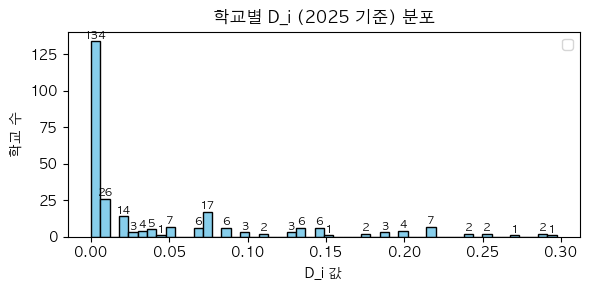

In [16]:
# inf, -inf, NaN 제거
data = df_result_4['D_i(2025)'].replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(6, 3))

# 히스토그램 그리기
counts, bin_edges, patches = plt.hist(
    data, 
    bins=50, 
    color='skyblue', 
    edgecolor='black'
)

# 각 막대 위에 숫자 표시
for count, x in zip(counts, bin_edges[:-1]):
    if count > 0:
        plt.text(
            x + (bin_edges[1] - bin_edges[0])/2,
            count + 0.5,
            int(count),
            ha='center', va='bottom', fontsize=8
        )

plt.title("학교별 D_i (2025 기준) 분포")
plt.xlabel("D_i 값")
plt.ylabel("학교 수")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
m = folium.Map(location=[36.8, 127.7], zoom_start=9)

# 모든 학교에 대해 점 + 반경 원 표시
for idx, row in df_24_schools.iterrows():
    lat = row['new위도']
    lon = row['new경도']
    school_name = row['학교명']
    폐교여부 = row['폐교여부']
    
    # 폐교 여부에 따라 색상 결정
    color = 'red' if 폐교여부 == 'Y' else 'green'
    
    # 반경 원 추가
    folium.Circle(
        location=[lat, lon],
        radius = mean_nearest_distance * 1000,  # m
        color=color,  # 원 테두리 색도 폐교여부에 따라
        fill=True,
        fill_color=color,
        fill_opacity=0.1,  # 연하게
        weight=1
    ).add_to(m)

    # 학교 위치 점 추가
    folium.CircleMarker(
        location=[lat, lon],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.9,
        popup=f"{school_name} (폐교여부: {폐교여부})"
    ).add_to(m)

m

## 1.5 전체학생수 ($X_i$)

In [18]:
df_24_5 = df_24[df_24['지역'].fillna('').str.contains('충청북도')][['지역', '학교명', '전체학생수(계)']].sort_values('전체학생수(계)')

In [19]:
df_23_5 = df_23[df_23['지역'].fillna('').str.contains('충청북도')][['지역', '학교명', '전체학생수(계)']].sort_values('전체학생수(계)')

In [20]:
df_22_5 = df_22[df_22['지역'].fillna('').str.contains('충청북도')][['지역', '학교명', '전체학생수(계)']].sort_values('전체학생수(계)')

In [21]:
# 1. 우선, 각 데이터프레임의 '학교명' 기준으로 병합
df_merge = df_24_5.merge(df_23_5, on='학교명', how='inner', suffixes=('_2024', '_2023'))
df_merge = df_merge.merge(df_22_5, on='학교명', how='inner')

# 2. 컬럼 정리
# df_22_5에는 suffix가 없으니까 추가로 이름을 변경
df_merge = df_merge.rename(columns={
    '지역': '지역_2022',
    '전체학생수(계)': '전체학생수(계)_2022'
})

# 3. 최종 컬럼 구성
df_merge = df_merge[['학교명','전체학생수(계)_2024','전체학생수(계)_2023','전체학생수(계)_2022']]
# 4. 3개년 전체학생수 평균 계산
df_merge['X_i(2025)'] = np.ceil(
    df_merge[['전체학생수(계)_2022', '전체학생수(계)_2023', '전체학생수(계)_2024']].mean(axis=1)
).astype(int)

df_result_5 = df_merge[['학교명', 'X_i(2025)']].sort_values('X_i(2025)')
# df_result_5['X_i(2025)'] = -df_result_5['X_i(2025)']
df_result_5.to_csv(path+'\SCR_data\5-X_i(2025).csv')
df_result_5

,학교명,X_i(2025)
0,가곡초등학교보발분교장,2
1,용원초등학교동락분교장,3
2,영춘초등학교별방분교장,4
5,판동초등학교송죽분교장,6
4,증약초등학교대정분교장,7
...,...,...
263,창리초등학교,1405
261,산성초등학교,1435
259,각리초등학교,1442
265,중앙초등학교,1662


In [22]:
df_merge[df_merge['학교명'].str.contains('')].sort_values('X_i(2025)')[:30]

,학교명,전체학생수(계)_2024,전체학생수(계)_2023,전체학생수(계)_2022,X_i(2025)
0,가곡초등학교보발분교장,1.0,2.0,3.0,2
1,용원초등학교동락분교장,2.0,6.0,0.0,3
2,영춘초등학교별방분교장,5.0,6.0,0.0,4
5,판동초등학교송죽분교장,7.0,10.0,0.0,6
4,증약초등학교대정분교장,6.0,7.0,6.0,7
3,미원초등학교금관분교장,5.0,8.0,12.0,9
9,한송초등학교,15.0,12.0,12.0,13
8,회남초등학교,15.0,12.0,15.0,14
7,산외초등학교,12.0,15.0,16.0,15
6,수산초등학교,11.0,15.0,21.0,16


## 1.6 df_result_1, df_result_2, df_result_3, df_result_4,외부조인

In [23]:
# ✅ 첫 번째 병합 (df_result_1 + df_result_2)
df_merge_1_2 = pd.merge(
    df_result_1,
    df_result_2,
    on=['지역', '학교명'],
    how='outer'
)

# ✅ 두 번째 병합 (df_merge_1_2 + df_result_4)
df_merge_1_2_4 = pd.merge(
    df_merge_1_2,
    df_result_4,
    on=['지역', '학교명'],
    how='outer'
)

df_merge_1_2_4['지역'] = df_merge_1_2_4['지역'].replace('충청북도 청원군', '충청북도 청주시')
df_merge_1_2_4

,지역,학교명,S_i(2025),T_i (2025),D_i(2025)
0,충청북도 괴산군,감물초등학교,-0.057043,-0.061153,0.071429
1,충청북도 괴산군,괴산명덕초등학교,0.121450,0.040922,0.142857
2,충청북도 괴산군,동인초등학교,0.077630,-0.003571,0.142857
3,충청북도 괴산군,목도초등학교,-0.054970,-0.067127,0.071429
4,충청북도 괴산군,문광초등학교,-0.054032,0.005848,0.142857
...,...,...,...,...,...
265,충청북도 충주시,충주용산초등학교,0.068874,-0.005292,0.108108
266,충청북도 충주시,충주중앙초등학교,0.014602,0.021007,0.216216
267,충청북도 충주시,충주중앙탑초등학교,-0.066565,-0.021174,0.000000
268,충청북도 충주시,칠금초등학교,0.107447,0.032160,0.243243


In [24]:
# '지역'에서 마지막 단어 추출해서 '행정구역' 컬럼 생성
df_merge_1_2_4['행정구역'] = df_merge_1_2_4['지역'].apply(lambda x: str(x).split()[-1])

# '지역', '학교명'을 기준으로 중복 제거하면서, 결측값을 서로 채워서 합침
df_merge_1_2_4 = df_merge_1_2_4.groupby(['지역', '학교명'], as_index=False).first()

In [25]:
# 병합 (left join)
df_merged_1_2_3_4 = pd.merge(
    df_merge_1_2_4,
    df_result_3,
    on='행정구역',
    how='left'
)

df_merged_1_2_3_4 = df_merged_1_2_3_4.drop('행정구역',axis=1)
df_merged_1_2_3_4 = df_merged_1_2_3_4[['지역','학교명','S_i(2025)','T_i (2025)','B_i(2025)', 'D_i(2025)']]
df_merged_1_2_3_4

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025)
0,충청북도 괴산군,감물초등학교,-0.057043,-0.061153,1.88,0.071429
1,충청북도 괴산군,괴산명덕초등학교,0.121450,0.040922,1.88,0.142857
2,충청북도 괴산군,동인초등학교,0.077630,-0.003571,1.88,0.142857
3,충청북도 괴산군,목도초등학교,-0.054970,-0.067127,1.88,0.071429
4,충청북도 괴산군,문광초등학교,-0.054032,0.005848,1.88,0.142857
...,...,...,...,...,...,...
264,충청북도 충주시,충주용산초등학교,0.068874,-0.005292,4.48,0.108108
265,충청북도 충주시,충주중앙초등학교,0.014602,0.021007,4.48,0.216216
266,충청북도 충주시,충주중앙탑초등학교,-0.066565,-0.021174,4.48,0.000000
267,충청북도 충주시,칠금초등학교,0.107447,0.032160,4.48,0.243243


In [26]:
# 병합 (left join)
df_merged_1_2_3_4_5 = pd.merge(
    df_merged_1_2_3_4,
    df_result_5,
    on='학교명',
    how='left'
)

df_merged_1_2_3_4_5

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025),X_i(2025)
0,충청북도 괴산군,감물초등학교,-0.057043,-0.061153,1.88,0.071429,53.0
1,충청북도 괴산군,괴산명덕초등학교,0.121450,0.040922,1.88,0.142857,136.0
2,충청북도 괴산군,동인초등학교,0.077630,-0.003571,1.88,0.142857,287.0
3,충청북도 괴산군,목도초등학교,-0.054970,-0.067127,1.88,0.071429,51.0
4,충청북도 괴산군,문광초등학교,-0.054032,0.005848,1.88,0.142857,60.0
...,...,...,...,...,...,...,...
264,충청북도 충주시,충주용산초등학교,0.068874,-0.005292,4.48,0.108108,622.0
265,충청북도 충주시,충주중앙초등학교,0.014602,0.021007,4.48,0.216216,315.0
266,충청북도 충주시,충주중앙탑초등학교,-0.066565,-0.021174,4.48,0.000000,995.0
267,충청북도 충주시,칠금초등학교,0.107447,0.032160,4.48,0.243243,390.0


능산초등학교 - df_result_1,df_result_4 에 없음 -> 2023년 3월 1일 폐교   
영춘초등학교별방분교장 - df_result_1 에 없음 -> 2022년 3월 1일 개교   
오송솔미초등학교 - df_result_1, df_result_2 에 없음 -> 2025년 3월 1일 개교   
용원초등학교동락분교장 - df_result_1 에 없음 -> 2022년 3월 1일 개교   
판동초등학교송죽분교장 - df_result_1 에 없음 -> 2022년 3월 1일 개교   

In [27]:
df_merged_1_2_3_4_5[df_merged_1_2_3_4_5.isnull().any(axis=1)].sort_values('학교명')

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025),X_i(2025)
72,충청북도 음성군,능산초등학교,NaN,0.105263,4.28,NaN,NaN
26,충청북도 단양군,영춘초등학교별방분교장,NaN,0.122222,2.24,0.000000,4.0
193,충청북도 청주시,오송솔미초등학교,NaN,NaN,6.00,0.000000,NaN
253,충청북도 충주시,용원초등학교동락분교장,NaN,0.166667,4.48,0.000000,3.0
39,충청북도 보은군,판동초등학교송죽분교장,NaN,0.047619,2.64,0.133333,6.0


In [28]:
df_merged_1_2_3_4_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   지역          269 non-null    object 
 1   학교명         269 non-null    object 
 2   S_i(2025)   264 non-null    float64
 3   T_i (2025)  268 non-null    float64
 4   B_i(2025)   269 non-null    float64
 5   D_i(2025)   268 non-null    float64
 6   X_i(2025)   267 non-null    float64
dtypes: float64(5), object(2)
memory usage: 14.8+ KB


In [30]:
from sklearn.preprocessing import StandardScaler

# ✅ 스케일링 대상 컬럼 지정
scale_cols = ['S_i(2025)', 'T_i (2025)', 'B_i(2025)', 'D_i(2025)', 'X_i(2025)']

# ✅ StandardScaler로 표준화
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_merged_1_2_3_4_5[scale_cols])

# ✅ 결과를 데이터프레임으로 다시 넣기
df_merged_1_2_3_4_5 = df_merged_1_2_3_4_5.copy()
df_merged_1_2_3_4_5[scale_cols] = scaled_values

# ✅ 결과 확인
df_merged_1_2_3_4_5

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025),X_i(2025)
0,충청북도 괴산군,감물초등학교,-0.367178,-0.655046,-1.881878,0.407381,-0.702696
1,충청북도 괴산군,괴산명덕초등학교,0.572723,0.335999,-1.881878,1.439662,-0.477566
2,충청북도 괴산군,동인초등학교,0.341977,-0.095985,-1.881878,1.439662,-0.067993
3,충청북도 괴산군,목도초등학교,-0.356264,-0.713046,-1.881878,0.407381,-0.708121
4,충청북도 괴산군,문광초등학교,-0.351322,-0.004536,-1.881878,1.439662,-0.683709
...,...,...,...,...,...,...,...
264,충청북도 충주시,충주용산초등학교,0.295868,-0.112696,-0.080611,0.937471,0.840663
265,충청북도 충주시,충주중앙초등학교,0.010085,0.142647,-0.080611,2.499843,0.007954
266,충청북도 충주시,충주중앙탑초등학교,-0.417316,-0.266887,-0.080611,-0.624900,1.852390
267,충청북도 충주시,칠금초등학교,0.498982,0.250930,-0.080611,2.890436,0.211385


In [31]:
df_merged_1_2_3_4_5.to_csv(path + '/SCR_data/merged_STBDX(2025).csv')

# 2. 가중치 설정

In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. 데이터 준비
X = df_merged_1_2_3_4_5[['S_i(2025)',
                         # 'T_i (2025)',
                         'B_i(2025)',
                         'D_i(2025)',
                         'X_i(2025)'
                         ]].dropna()

# 3. PCA
pca = PCA()
pca.fit(X)

# 4. 첫 번째 주성분(PC1)의 계수 가져오기
pc1_loadings = pca.components_[0]

# 5. 결과 정리
weights = pd.Series(pc1_loadings, index=['S_i(2025)',
                                         # 'T_i(2025)',
                                         'B_i(2025)', 'D_i(2025)', 'X_i(2025)'])
weights = weights / weights.abs().sum()  # 절댓값 기준으로 정규화해도 좋음

print(weights)

S_i(2025)   -0.129052
B_i(2025)    0.384173
D_i(2025)   -0.163150
X_i(2025)    0.323626
dtype: float64


In [33]:
# # 1. PC1, PC2 계수 가져오기
# pc1_loadings = pca.components_[0]
# pc2_loadings = pca.components_[1]

# # 2. 주성분 설명비율 가져오기
# explained_variance = pca.explained_variance_ratio_

# # 3. 비율 가중 합 계산
# combined_loadings = pc1_loadings * explained_variance[0] + pc2_loadings * explained_variance[1]

# # 4. 정리
# weights = pd.Series(combined_loadings, index=['S_i(2025)',
#                                               # 'T_i(2025)',
#                                               'B_i(2025)', 'D_i(2025)', 'X_i(2025)'])
# weights = weights / weights.abs().sum()  # 절댓값 합 1로 정규화 (선택사항)

# print(weights)

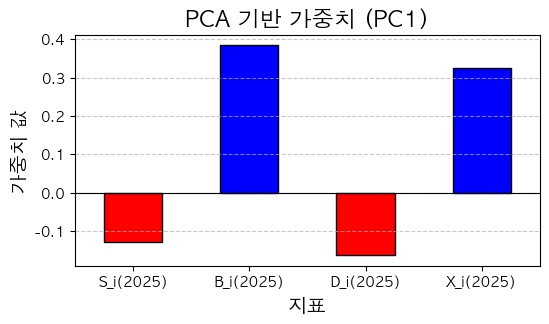

In [34]:
import matplotlib.pyplot as plt

# ✅ 막대그래프 그리기
plt.figure(figsize=(6, 3))
weights.plot(kind='bar', color=['red' if w < 0 else 'blue' for w in weights], edgecolor='black')

# ✅ 세부 설정
plt.title('PCA 기반 가중치 (PC1)', fontsize=16)
plt.xlabel('지표', fontsize=14)
plt.ylabel('가중치 값', fontsize=14)
plt.axhline(0, color='black', linewidth=0.8)  # 기준선
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [36]:
df_merged_1_2_3_4_5

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025),X_i(2025)
0,충청북도 괴산군,감물초등학교,-0.367178,-0.655046,-1.881878,0.407381,-0.702696
1,충청북도 괴산군,괴산명덕초등학교,0.572723,0.335999,-1.881878,1.439662,-0.477566
2,충청북도 괴산군,동인초등학교,0.341977,-0.095985,-1.881878,1.439662,-0.067993
3,충청북도 괴산군,목도초등학교,-0.356264,-0.713046,-1.881878,0.407381,-0.708121
4,충청북도 괴산군,문광초등학교,-0.351322,-0.004536,-1.881878,1.439662,-0.683709
...,...,...,...,...,...,...,...
264,충청북도 충주시,충주용산초등학교,0.295868,-0.112696,-0.080611,0.937471,0.840663
265,충청북도 충주시,충주중앙초등학교,0.010085,0.142647,-0.080611,2.499843,0.007954
266,충청북도 충주시,충주중앙탑초등학교,-0.417316,-0.266887,-0.080611,-0.624900,1.852390
267,충청북도 충주시,칠금초등학교,0.498982,0.250930,-0.080611,2.890436,0.211385


### 가중치조정

In [1079]:
# ✅ SCR 계산
df_scr = df_merged_1_2_3_4_5.copy()

# Null 없는 행만 계산
df_scr = df_scr.dropna(subset=['S_i(2025)', 'B_i(2025)', 'D_i(2025)', 'X_i(2025)'])

# 가중치 직접 지정
weight_X = -0.1
weight_S = 0.1
weight_B = -0.3
weight_D = 0.5

# S_i(2025)    0.162888
# B_i(2025)    0.289061
# D_i(2025)    0.543448
# X_i(2025)   -0.004603

# SCR 공식 적용
df_scr['SCR(2025)'] = (
    df_scr['S_i(2025)'] * weight_S +
    df_scr['B_i(2025)'] * weight_B +
    df_scr['D_i(2025)'] * weight_D +
    df_scr['X_i(2025)'] * weight_X
)

# ✅ 결과 정렬
df_scr = df_scr.sort_values('SCR(2025)', ascending=False)

# 결과 출력
df_scr

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025),X_i(2025),SCR(2025)
56,충청북도 옥천군,군남초등학교,0.327439,-0.203591,-1.272219,3.504224,-0.670147,2.233536
64,충청북도 옥천군,장야초등학교,0.284569,-0.197801,-1.272219,3.504224,0.428377,2.119397
255,충청북도 충주시,충주교현초등학교,0.201230,-0.187033,-0.080611,3.671621,-0.152078,1.895325
263,충청북도 충주시,충주예성초등학교,0.265046,0.024621,-0.080611,3.281029,-0.496553,1.740858
65,충청북도 옥천군,죽향초등학교,0.332249,0.137413,-1.272219,2.471943,-0.114104,1.662273
...,...,...,...,...,...,...,...,...
216,충청북도 청주시,창리초등학교,-0.545288,0.354187,0.972437,-0.624900,2.964476,-0.955158
212,충청북도 청주시,중앙초등학교,0.054793,0.000744,0.972437,-0.624900,3.661564,-0.964858
187,충청북도 청주시,솔밭초등학교,-0.096198,-0.138618,0.972437,-0.624900,4.160647,-1.029866
204,충청북도 청주시,운동초등학교,-8.852438,-2.311062,0.972437,-0.332942,0.865074,-1.429953


In [1080]:
# df_scr.to_csv(path+'SCR_data/SCR_result.csv')

In [1081]:
# 1. 상위 5%와 15% 커트라인 계산
upper_5 = df_scr['SCR(2025)'].quantile(0.96)
upper_15 = df_scr['SCR(2025)'].quantile(0.87)

# 2. 새로운 컬럼 생성: 초기값은 '안전'
df_scr['폐교위험등급'] = '안전'

# 3. 조건에 따라 '주의'와 '위험' 레이블링
df_scr.loc[(df_scr['SCR(2025)'] >= upper_15) & (df_scr['SCR(2025)'] < upper_5), '폐교위험등급'] = '주의'
df_scr.loc[df_scr['SCR(2025)'] >= upper_5, '폐교위험등급'] = '위험'

In [1082]:
# df_scr.to_csv(path+'/SCR_data/SCR_result_rank.csv')

In [1083]:
len(df_scr[df_scr['폐교위험등급'] == '위험'].sort_values('SCR(2025)', ascending=False))

11

In [1084]:
df_scr[df_scr['폐교위험등급'] == '주의'].sort_values('SCR(2025)', ascending=False)

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025),X_i(2025),SCR(2025),폐교위험등급
267,충청북도 충주시,칠금초등학교,0.498982,0.250930,-0.080611,2.890436,0.211385,1.498161,주의
60,충청북도 옥천군,삼양초등학교,-0.023610,0.028441,-1.272219,2.471943,1.296347,1.485642,주의
1,충청북도 괴산군,괴산명덕초등학교,0.572723,0.335999,-1.881878,1.439662,-0.477566,1.389424,주의
250,충청북도 충주시,연수초등학교,0.442541,0.014954,-0.080611,2.499843,-0.472141,1.365573,주의
2,충청북도 괴산군,동인초등학교,0.341977,-0.095985,-1.881878,1.439662,-0.067993,1.325392,주의
4,충청북도 괴산군,문광초등학교,-0.351322,-0.004536,-1.881878,1.439662,-0.683709,1.317633,주의
265,충청북도 충주시,충주중앙초등학교,0.010085,0.142647,-0.080611,2.499843,0.007954,1.274318,주의
268,충청북도 충주시,탄금초등학교,0.256046,-0.031132,-0.080611,2.499843,1.193275,1.180382,주의
58,충청북도 옥천군,동이초등학교,-0.328468,-0.558178,-1.272219,1.439662,-0.729820,1.141632,주의
92,충청북도 제천시,남당초등학교,0.262376,0.058310,-0.399297,1.888480,-0.464004,1.136667,주의


In [1085]:
df_scr[df_scr['폐교위험등급'] == '안전'].sort_values('SCR(2025)', ascending=False)

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025),X_i(2025),SCR(2025),폐교위험등급
19,충청북도 단양군,단천초등학교,0.135696,0.112155,-1.632472,0.486787,-0.754232,0.822128,안전
20,충청북도 단양군,대가초등학교,0.073289,0.618781,-1.632472,0.486787,-0.789493,0.819414,안전
15,충청북도 단양군,가곡초등학교대곡분교장,0.065072,-1.792951,-1.632472,0.486787,-0.773218,0.816964,안전
22,충청북도 단양군,매포초등학교,0.370640,0.320391,-1.632472,0.486787,-0.458579,0.816057,안전
3,충청북도 괴산군,목도초등학교,-0.356264,-0.713046,-1.881878,0.407381,-0.708121,0.803440,안전
...,...,...,...,...,...,...,...,...,...
216,충청북도 청주시,창리초등학교,-0.545288,0.354187,0.972437,-0.624900,2.964476,-0.955158,안전
212,충청북도 청주시,중앙초등학교,0.054793,0.000744,0.972437,-0.624900,3.661564,-0.964858,안전
187,충청북도 청주시,솔밭초등학교,-0.096198,-0.138618,0.972437,-0.624900,4.160647,-1.029866,안전
204,충청북도 청주시,운동초등학교,-8.852438,-2.311062,0.972437,-0.332942,0.865074,-1.429953,안전


In [1086]:
# X_i(2025)   -0.384
# S_i(2025)   0.129
# B_i(2025)   -0.324
# D_i(2025)   0.163

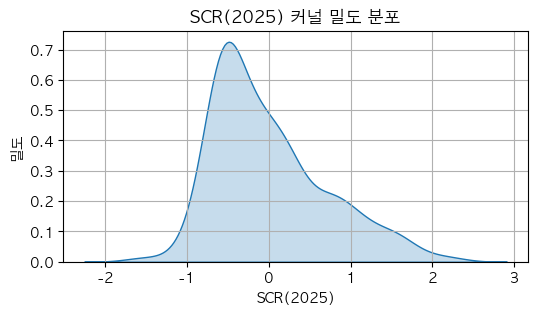

In [1087]:
import seaborn as sns

# ✅ KDE 플롯 그리기
plt.figure(figsize=(6,3))
sns.kdeplot(df_scr['SCR(2025)'], fill=True)
plt.title('SCR(2025) 커널 밀도 분포')
plt.xlabel('SCR(2025)')
plt.ylabel('밀도')
plt.grid(True)
plt.show()

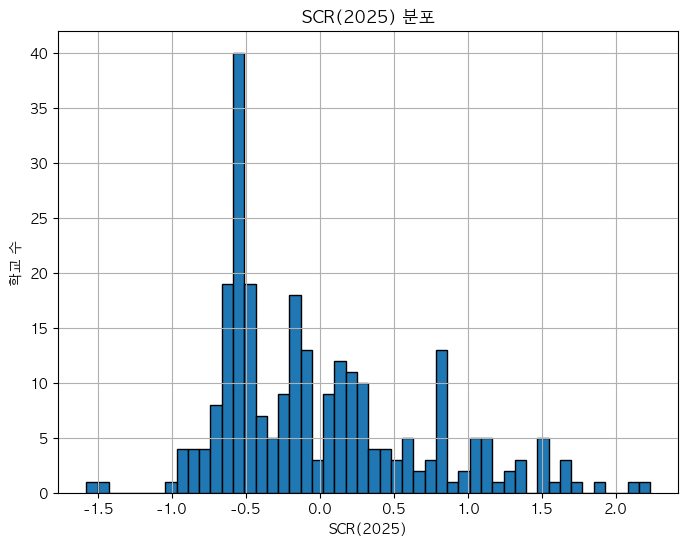

In [1088]:
# ✅ 히스토그램 그리기
plt.figure(figsize=(8,6))
plt.hist(df_scr['SCR(2025)'], bins=50, edgecolor='black')
plt.title('SCR(2025) 분포')
plt.xlabel('SCR(2025)')
plt.ylabel('학교 수')
plt.grid(True)
plt.show()

## 시각화

In [1089]:
df_already_gone_schools = pd.read_csv(path + '폐교데이터목록_new위도_new경도.csv')
df_already_gone_schools

,Unnamed: 0,시도교육청,폐교명,폐교연도,지역교육청,급별,활용현황,주소,new위도,new경도
0,4,충북,(구)북암초,1981,보은,초,대부,보은군 속리산면 북암리 318,36.546074,127.786825
1,144,충북,속리초 장재분교장,1982,보은,초,매각,보은군 외속리면 장재리 208,NaN,NaN
2,111,충북,산수초,1982,충주,초,매각,충주시 신니면 마수리 191-3,36.974369,127.746790
3,246,충북,한수초,1983,제천,초,매각,제천시 한수면 황강리 327,36.953634,128.052032
4,198,충북,운학초 차도분교장,1983,제천,초,매각,제천시 백운면 운학리 648,37.228214,127.997595
...,...,...,...,...,...,...,...,...,...,...
236,167,충북,야동초,2020,충주,초,대부,충주시 소태면 야동리 487,37.099943,127.877606
237,62,충북,대소원초,2020,충주,초,자체활용,충주시 대소원면 본리 569-15,36.975188,127.825510
238,207,충북,입석초,2021,제천,초,대부,제천시 송학면 입석리 609-2,37.199613,128.293585
239,3,충북,(구)복대초,2023,청주,초,자체활용,청주시 흥덕구 복대동 709-4,36.629145,127.447843


In [1090]:
# 1. '폐교연도' 열에서 NaN 제거
df_check = df_already_gone_schools.dropna(subset=['폐교연도']).copy()

# 2. '폐교연도'를 int로 변환
df_check['폐교연도'] = df_check['폐교연도'].astype(int)

# 3. 5년 단위로 bin 구간 설정
bins = list(range(1980, 2026, 5))  # 1980, 1985, ..., 2020
labels = [f"{start}~{start+4}" for start in bins[:-1]]  # '1980~1984', '1985~1989', ..., '2020~2024'

# 4. '폐교연도'를 5년 단위로 분류
df_check['5년구간'] = pd.cut(df_check['폐교연도'], bins=bins, labels=labels, right=True, include_lowest=True)

# 5. 각 그룹별 개수 세기
group_counts = df_check['5년구간'].value_counts().sort_index()

# 결과 출력
print(group_counts)


5년구간
1980~1984     6
1985~1989    21
1990~1994    97
1995~1999    64
2000~2004    12
2005~2009    12
2010~2014    12
2015~2019    14
2020~2024     3
Name: count, dtype: int64


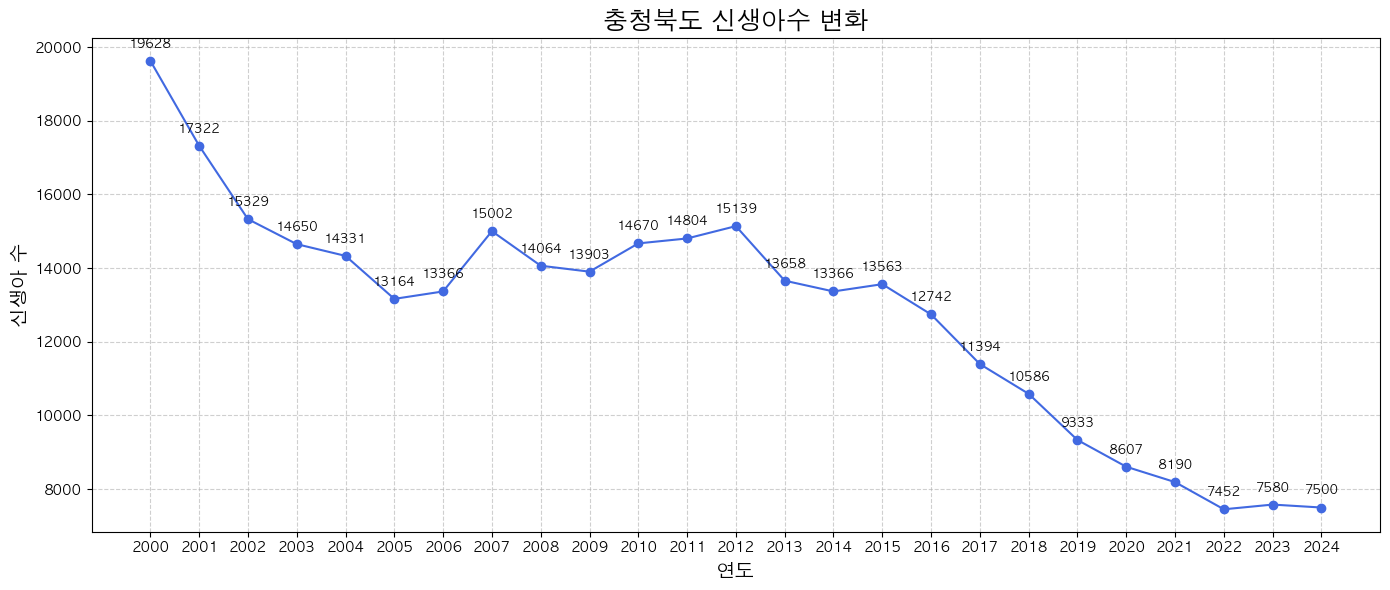

In [1091]:
df_cb_babies_2000 = pd.read_csv(path + '시군구_출생아수__합계출산율_20250429094252.csv')
df_cb_babies_2000 = df_cb_babies_2000[df_cb_babies_2000['시군구별'] == '충청북도'][['2000', '2001', '2002', '2003', '2004', '2005', '2006',
                                                        '2007', '2008', '2009', '2010', '2011', '2012', '2013',
                                                        '2014', '2015', '2016', '2017', '2018', '2019', '2020',
                                                        '2021', '2022', '2023', '2024 p)']]
df_cb_babies_2000 = df_cb_babies_2000.rename(columns={'2024 p)': '2024'})

# 1. 연도와 신생아 수 추출
years = df_cb_babies_2000.columns.astype(int)  # 열 이름은 연도
baby_counts = df_cb_babies_2000.iloc[0].astype(int).values  # 데이터도 int로 변환


# 2. 그래프 기본 설정
plt.figure(figsize=(14, 6))

# 3. 꺾은선 그래프 그리기
plt.plot(years, baby_counts, marker='o', linestyle='-', color='royalblue')

# 4. 제목, 라벨 설정
plt.title('충청북도 신생아수 변화', fontsize=18)
plt.xlabel('연도', fontsize=14)
plt.ylabel('신생아 수', fontsize=14)

# 5. x축 눈금 간격 조정 (1년 단위 표시)
plt.xticks(ticks=years)

# 6. 그리드 추가
plt.grid(True, linestyle='--', alpha=0.6)

# 7. 데이터 값 표시 (선 위에)
for x, y in zip(years, baby_counts):
    plt.text(x, y + 300, f'{y}', ha='center', va='bottom', fontsize=9)

# 8. 레이아웃 정리
plt.tight_layout()

# 9. 그래프 출력
plt.show()

In [1092]:
df_all_school_info = pd.read_csv(path + '학교기본정보(초)_충청북도교육청.csv')
df_all_school_info['개교기념일'].sort_values()

212    18960917.0
217    19041101.0
81     19050401.0
252    19050404.0
53     19060401.0
          ...    
293    20201010.0
294    20220301.0
295    20220301.0
291    20250301.0
8             NaN
Name: 개교기념일, Length: 297, dtype: float64

In [1093]:
df_all_school_info.columns

Index(['시도교육청', '교육지원청', '지역', '정보공시 학교코드', '학교명', '학교급코드', '설립구분', '학교특성',
       '분교여부', '설립유형', '주야구분', '개교기념일', '설립일', '법정동코드', '주소내역', '상세주소내역',
       '우편번호', '학교도로명 우편번호', '학교도로명 주소', '학교도로명 상세주소', '위도', '경도', '전화번호',
       '팩스번호', '홈페이지 주소', '남녀공학 구분', '폐교여부', '폐교일자', '휴교여부'],
      dtype='object')

In [1094]:
len(df_all_school_info)

297

In [1095]:
df_all_school_info['개교기념일'].sort_values(ascending=False)

291    20250301.0
295    20220301.0
294    20220301.0
293    20201010.0
289    20200901.0
          ...    
252    19050404.0
81     19050401.0
217    19041101.0
212    18960917.0
8             NaN
Name: 개교기념일, Length: 297, dtype: float64

In [1096]:
df_all_school_info[df_all_school_info['폐교여부'] == 'Y'].sort_values('폐교일자').head()

,시도교육청,교육지원청,지역,정보공시 학교코드,학교명,학교급코드,설립구분,학교특성,분교여부,설립유형,...,학교도로명 상세주소,위도,경도,전화번호,팩스번호,홈페이지 주소,남녀공학 구분,폐교여부,폐교일자,휴교여부
237,충청북도교육청,충청북도충주교육지원청,충청북도 충주시,S110001030,엄정초등학교목계분교장,2,공립,NaN,Y,단설,...,NaN,NaN,NaN,038521516,043-851-4764,NaN,NaN,Y,20090301.0,N
8,충청북도교육청,충청북도괴산증평교육지원청,충청북도 괴산군,S110000298,문광초등학교덕평분교장,2,공립,NaN,Y,NaN,...,NaN,NaN,NaN,016-457-9247,043-833-6291,NaN,NaN,Y,20110228.0,N
150,충청북도교육청,NaN,NaN,S110000830,남일초등학교두산분교장,2,공립,NaN,Y,부속,...,NaN,NaN,NaN,01064099694,043-292-5624,www.namil-e.es.kr,NaN,Y,20110228.0,N
171,충청북도교육청,NaN,NaN,S110000874,외천초등학교,2,공립,NaN,N,단설,...,(부용면),36.540986,127.432369,0430-260-6221,043-260-4669,http://www.oe-cheon.es.kr,남녀공학,Y,20120229.0,N
77,충청북도교육청,충청북도옥천교육지원청,충청북도 옥천군,S110000594,이원초등학교지탄분교장,2,공립,NaN,Y,단설,...,NaN,36.243348,127.681950,043-732-2451,043-733-4624,NaN,남녀공학,Y,20120301.0,N


In [1097]:
df_all_school_info['폐교일자'].sort_values()

237    20090301.0
8      20110228.0
150    20110228.0
171    20120229.0
77     20120301.0
          ...    
292           NaN
293           NaN
294           NaN
295           NaN
296           NaN
Name: 폐교일자, Length: 297, dtype: float64

In [1098]:
df_24_schools[df_24_schools['폐교여부'] == 'Y']

,Unnamed: 0,학교명,학교도로명 주소,폐교여부,new위도,new경도
8,8,문광초등학교덕평분교장,충청북도 괴산군 청천면 송문로덕평2길 42,Y,36.730483,127.796632
11,11,보광초등학교화곡분교장,충청북도 괴산군 사리면 모래재로 941,Y,36.800494,127.712900
21,21,추산초등학교,충청북도 괴산군 불정면 동추산길 1,Y,36.902766,127.817701
29,29,단천초등학교가산분교장,충청북도 단양군 단성면 선암계곡로 1092,Y,36.893309,128.305517
32,32,대강초등학교장정분교장,충청북도 단양군 대강면 온천로 719-7,Y,36.846632,128.395263
34,34,별방초등학교,충청북도 단양군 영춘면 별방창원로 449,Y,37.096357,128.415812
45,45,송죽초등학교,충청북도 보은군 삼승면 남부로 3927,Y,36.437957,127.734841
47,47,수정초등학교삼가분교장,충청북도 보은군 속리산면 삼가구병길 9,Y,36.490947,127.860049
55,55,미봉초등학교,충청북도 영동군 양강면 학산영동로 495,Y,36.127981,127.727205
75,75,대성초등학교,충청북도 옥천군 이원면 이원로 443,Y,36.212902,127.630257


In [1099]:
# 1. 폐교된 학교만 추출
df_closed = df_24_schools[df_24_schools['폐교여부'] == 'Y'].copy()

# 2. '학교명' 기준으로 left join
df_closed = df_closed.merge(
    df_all_school_info[['학교명', '폐교일자']],
    on='학교명',
    how='left'
)

# 결과 확인
# 특정 학교의 폐교일자 수정
df_closed.loc[df_closed['학교명'] == '남신초등학교덕생분교장', '폐교일자'] = 20120301
df_closed = df_closed.drop('Unnamed: 0', axis=1)
df_closed

,학교명,학교도로명 주소,폐교여부,new위도,new경도,폐교일자
0,문광초등학교덕평분교장,충청북도 괴산군 청천면 송문로덕평2길 42,Y,36.730483,127.796632,20110228.0
1,보광초등학교화곡분교장,충청북도 괴산군 사리면 모래재로 941,Y,36.800494,127.712900,20130301.0
2,추산초등학교,충청북도 괴산군 불정면 동추산길 1,Y,36.902766,127.817701,20170301.0
3,단천초등학교가산분교장,충청북도 단양군 단성면 선암계곡로 1092,Y,36.893309,128.305517,20190228.0
4,대강초등학교장정분교장,충청북도 단양군 대강면 온천로 719-7,Y,36.846632,128.395263,20170701.0
5,별방초등학교,충청북도 단양군 영춘면 별방창원로 449,Y,37.096357,128.415812,20220228.0
6,송죽초등학교,충청북도 보은군 삼승면 남부로 3927,Y,36.437957,127.734841,20220228.0
7,수정초등학교삼가분교장,충청북도 보은군 속리산면 삼가구병길 9,Y,36.490947,127.860049,20180301.0
8,미봉초등학교,충청북도 영동군 양강면 학산영동로 495,Y,36.127981,127.727205,20180301.0
9,대성초등학교,충청북도 옥천군 이원면 이원로 443,Y,36.212902,127.630257,20140301.0


In [1100]:
import ipywidgets as widgets
from IPython.display import display

# 1. 폐교 연도 추출 및 5년 단위 그룹 만들기
df_closed['폐교연도'] = df_closed['폐교일자'].astype(int) // 10000  # '20120301.0' → 2012
bins = list(range(2005, 2026, 5))
labels = [f"{start}~{start+4}" for start in bins[:-1]]
df_closed['5년구간'] = pd.cut(df_closed['폐교연도'], bins=bins, labels=labels, right=True, include_lowest=True)

# 2. 지도 생성
m = folium.Map(location=[36.8, 127.6], zoom_start=9.3, tiles='CartoDB positron')

# df_rank와 df_schools 병합
df_map = pd.merge(df_scr, df_24_schools[['학교명', 'new위도', 'new경도']], on='학교명', how='left')

# 3. 충청북도 경계선 추가
geojson_path = path + 'hangjeongdong_충청북도.geojson'
folium.GeoJson(
    geojson_path,
    name='충청북도 경계선',
    style_function=lambda feature: {
        'fillColor': 'none',
        'color': 'grey',
        'weight': 2,
        'opacity': 0.6
    }
).add_to(m)

# 4. FeatureGroup을 구간별로 생성
group_layers = {}

for label in labels:
    group = folium.FeatureGroup(name=f'폐교: {label}')
    
    df_group = df_closed[df_closed['5년구간'] == label]
    
    for idx, row in df_group.iterrows():
        if pd.notnull(row['new위도']) and pd.notnull(row['new경도']):
            tooltip_text = f"{row['학교명']} (폐교연도: {int(row['폐교연도'])})"
            folium.CircleMarker(
                location=[row['new위도'], row['new경도']],
                radius=4,
                color='black',
                fill=True,
                fill_color='black',
                fill_opacity=0.8,
                tooltip=tooltip_text
            ).add_to(group)
    
    group.add_to(m)
    group_layers[label] = group

# 5. 기존 정상/위험 학교 표시 (df_map 활용)
risk_group = folium.FeatureGroup(name='폐교 위험')  # 빨간색
caution_group = folium.FeatureGroup(name='폐교 주의')  # 주황색
safe_group = folium.FeatureGroup(name='폐교 안전')  # 초록색 (정상)

for idx, row in df_map.iterrows():
    if pd.notnull(row['new위도']) and pd.notnull(row['new경도']):
        tooltip_text = f"{row['학교명']} ({row['폐교위험등급']})"
        popup_text = f"""
        <b>학교명:</b> {row['학교명']}<br>
        <b>S_i(2025):</b> {row['S_i(2025)']:.3f}<br>
        <b>T_i(2025):</b> {row['T_i (2025)']:.3f}<br>
        <b>B_i(2025):</b> {row['B_i(2025)']:.3f}<br>
        <b>D_i(2025):</b> {row['D_i(2025)']:.3f}<br>
        <b>X_i(2025):</b> {row['X_i(2025)']:.3f}<br>
        <b>SCR(2025):</b> {row['SCR(2025)']:.3f}
        """
        
        marker = folium.CircleMarker(
            location=[row['new위도'], row['new경도']],
            radius=4,
            color=get_marker_color(row['폐교위험등급']),
            fill=True,
            fill_color=get_marker_color(row['폐교위험등급']),
            fill_opacity=0.7,
            tooltip=tooltip_text,
            popup=folium.Popup(popup_text, max_width=300)
        )
        
        # 폐교위험등급에 따라 그룹에 추가
        if row['폐교위험등급'] == '위험':
            marker.add_to(risk_group)
        elif row['폐교위험등급'] == '주의':
            marker.add_to(caution_group)
        else:
            marker.add_to(safe_group)

# 그룹 추가
risk_group.add_to(m)
caution_group.add_to(m)
safe_group.add_to(m)

# 6. LayerControl 추가
folium.LayerControl(collapsed=False).add_to(m)

# 7. 지도 출력
m

### 3. 폐교는 언제 되었는가?

In [1101]:
df_all_school_info = pd.read_csv(path + '학교기본정보(초)_충청북도교육청.csv')
df_all_school_info.columns

Index(['시도교육청', '교육지원청', '지역', '정보공시 학교코드', '학교명', '학교급코드', '설립구분', '학교특성',
       '분교여부', '설립유형', '주야구분', '개교기념일', '설립일', '법정동코드', '주소내역', '상세주소내역',
       '우편번호', '학교도로명 우편번호', '학교도로명 주소', '학교도로명 상세주소', '위도', '경도', '전화번호',
       '팩스번호', '홈페이지 주소', '남녀공학 구분', '폐교여부', '폐교일자', '휴교여부'],
      dtype='object')

In [1102]:
# '남신초등학교덕생분교장'의 폐교일자 결측값을 20220301로 수정
df_all_school_info.loc[
    (df_all_school_info['학교명'] == '남신초등학교덕생분교장'),
    '폐교일자'
] = 20120301

df_all_school_info[df_all_school_info['폐교여부'] == 'Y'][['지역', '학교명', '분교여부', '폐교여부', '폐교일자']].sort_values('폐교일자')

,지역,학교명,분교여부,폐교여부,폐교일자
237,충청북도 충주시,엄정초등학교목계분교장,Y,Y,20090301.0
8,충청북도 괴산군,문광초등학교덕평분교장,Y,Y,20110228.0
150,NaN,남일초등학교두산분교장,Y,Y,20110228.0
171,NaN,외천초등학교,N,Y,20120229.0
77,충청북도 옥천군,이원초등학교지탄분교장,Y,Y,20120301.0
85,충청북도 음성군,남신초등학교덕생분교장,Y,Y,20120301.0
228,충청북도 충주시,노은초등학교수상분교장,Y,Y,20130228.0
11,충청북도 괴산군,보광초등학교화곡분교장,Y,Y,20130301.0
138,NaN,진천삼수초등학교매산분교장,Y,Y,20130301.0
75,충청북도 옥천군,대성초등학교,N,Y,20140301.0


In [1103]:
path = '/Users/yniyunj/Desktop/교육공공데이터/데이터/002-전출입생수/'

df24 = pd.read_csv(path + '2024년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df23 = pd.read_csv(path + '2023년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df22 = pd.read_csv(path + '2022년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df21 = pd.read_csv(path + '2021년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df20 = pd.read_csv(path + '2020년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df19 = pd.read_csv(path + '2019년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df18 = pd.read_csv(path + '2018년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df17 = pd.read_csv(path + '2017년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df16 = pd.read_csv(path + '2016년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df15 = pd.read_csv(path + '2015년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df14 = pd.read_csv(path + '2014년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df13 = pd.read_csv(path + '2013년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df12 = pd.read_csv(path + '2012년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df11 = pd.read_csv(path + '2011년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df10 = pd.read_csv(path + '2010년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df09 = pd.read_csv(path + '2009년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')
df08 = pd.read_csv(path + '2008년도_전·출입 및 학업중단 학생 수(초)_전체.csv', encoding = 'utf-8')

In [1104]:
df10.head()

,시도교육청,교육지원청,지역,정보공시 학교코드,학교명,학교급코드,설립구분,제외여부,제외사유,1학년 전입학생수,...,4학년 전체학생수,5학년 전입학생수,5학년 전출학생수,5학년 전체학생수,6학년 전입학생수,6학년 전출학생수,6학년 전체 학생수,전입학생수(계),전출학생수(계),전체학생수(계)
0,서울특별시교육청,교육부,서울특별시 서초구,S000003511,서울교육대학교부설초등학교,2,국립,N,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,서울특별시교육청,교육부,서울특별시 종로구,S000003563,서울대학교사범대학부설초등학교,2,국립,N,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,서울특별시교육청,서울특별시강남서초교육지원청,서울특별시 강남구,S010000737,서울개원초등학교,2,공립,N,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,서울특별시교육청,서울특별시강남서초교육지원청,서울특별시 강남구,S010000738,서울개일초등학교,2,공립,N,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,서울특별시교육청,서울특별시강남서초교육지원청,서울특별시 강남구,S010000739,서울개포초등학교,2,공립,N,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1105]:
df_closed

,학교명,학교도로명 주소,폐교여부,new위도,new경도,폐교일자,폐교연도,5년구간
0,문광초등학교덕평분교장,충청북도 괴산군 청천면 송문로덕평2길 42,Y,36.730483,127.796632,20110228.0,2011,2010~2014
1,보광초등학교화곡분교장,충청북도 괴산군 사리면 모래재로 941,Y,36.800494,127.712900,20130301.0,2013,2010~2014
2,추산초등학교,충청북도 괴산군 불정면 동추산길 1,Y,36.902766,127.817701,20170301.0,2017,2015~2019
3,단천초등학교가산분교장,충청북도 단양군 단성면 선암계곡로 1092,Y,36.893309,128.305517,20190228.0,2019,2015~2019
4,대강초등학교장정분교장,충청북도 단양군 대강면 온천로 719-7,Y,36.846632,128.395263,20170701.0,2017,2015~2019
5,별방초등학교,충청북도 단양군 영춘면 별방창원로 449,Y,37.096357,128.415812,20220228.0,2022,2020~2024
6,송죽초등학교,충청북도 보은군 삼승면 남부로 3927,Y,36.437957,127.734841,20220228.0,2022,2020~2024
7,수정초등학교삼가분교장,충청북도 보은군 속리산면 삼가구병길 9,Y,36.490947,127.860049,20180301.0,2018,2015~2019
8,미봉초등학교,충청북도 영동군 양강면 학산영동로 495,Y,36.127981,127.727205,20180301.0,2018,2015~2019
9,대성초등학교,충청북도 옥천군 이원면 이원로 443,Y,36.212902,127.630257,20140301.0,2014,2010~2014


In [1106]:
# 연도별 데이터프레임을 연도 숫자와 매칭시킨 딕셔너리 만들기
year_df_map = {
    2008: df08, 2009: df09, 2010: df10, 2011: df11, 2012: df12,
    2013: df13, 2014: df14, 2015: df15, 2016: df16, 2017: df17,
    2018: df18, 2019: df19, 2020: df20, 2021: df21, 2022: df22,
    2023: df23, 2024: df24
}

# 결과를 저장할 리스트
results = []

# df_closed 순회
for idx, row in df_closed.iterrows():
    school_name = row['학교명']
    close_year = row['폐교연도']

    # 폐교 3,2,1년 전 연도
    year_minus_3 = close_year - 3
    year_minus_2 = close_year - 2
    year_minus_1 = close_year - 1

    # 각각 학생수 초기값
    student_3 = None
    student_2 = None
    student_1 = None

    if year_minus_3 in year_df_map:
        df_target = year_df_map[year_minus_3]
        student = df_target[df_target['학교명'] == school_name]['전체학생수(계)']
        if not student.empty and pd.notnull(student.values[0]):
            student_3 = int(student.values[0])

    if year_minus_2 in year_df_map:
        df_target = year_df_map[year_minus_2]
        student = df_target[df_target['학교명'] == school_name]['전체학생수(계)']
        if not student.empty and pd.notnull(student.values[0]):
            student_2 = int(student.values[0])

    if year_minus_1 in year_df_map:
        df_target = year_df_map[year_minus_1]
        student = df_target[df_target['학교명'] == school_name]['전체학생수(계)']
        if not student.empty and pd.notnull(student.values[0]):
            student_1 = int(student.values[0])

    # 결과 추가
    results.append({
        '학교명': school_name,
        '폐교연도': close_year,
        '폐교 3년전 학생수': student_3,
        '폐교 2년전 학생수': student_2,
        '폐교 1년전 학생수': student_1
    })

# 결과를 데이터프레임으로 변환
df_student_change = pd.DataFrame(results)
df_student_change['X_i'] = df_student_change[['폐교 3년전 학생수', '폐교 2년전 학생수', '폐교 1년전 학생수']].mean(axis=1)

# 1. 복사본 생성
df_student_change = df_student_change.copy()

# 2. S_i 계산 함수 만들기
def calculate_S_i(row):
    nums = [
        (row['폐교 3년전 학생수'], row['폐교 2년전 학생수']),
        (row['폐교 2년전 학생수'], row['폐교 1년전 학생수'])
    ]
    
    growth_rates = []
    
    for earlier, later in nums:
        if pd.notnull(earlier) and pd.notnull(later) and earlier != 0:
            rate = (later - earlier) / earlier
            growth_rates.append(rate)
    
    # 평균 내기
    if growth_rates:
        return sum(growth_rates) / len(growth_rates)
    else:
        return None

# 3. 'S_i' 열 추가
df_student_change['S_i'] = df_student_change.apply(calculate_S_i, axis=1)

## D_i

# 1. 폐교 학교 좌표
coords_closed = np.radians(df_closed[['new위도', 'new경도']].values)

# 2. 거리 행렬 계산 (단위: 라디안 거리 × 지구 반지름 6371km)
dist_matrix = haversine_distances(coords_closed) * 6371

# 3. 자기 자신과의 거리는 무한대로 설정
np.fill_diagonal(dist_matrix, np.inf)

# 4. 각 학교별로 가장 가까운 거리 계산
min_distances = dist_matrix.min(axis=1)

# 5. 중앙값으로 반경 설정
median_nearest_distance = np.median(min_distances)

# 6. 반경 내 이웃 개수 세기
D_i_values = (dist_matrix <= median_nearest_distance).sum(axis=1)

# 7. D_i(2025) 결과 추가
df_student_change['D_i'] = D_i_values

## 행정구역 만들기
# 1. 데이터 복사
df_student_change = df_student_change.copy()

# 2. '학교도로명 주소'를 이용해 '행정구역' 만들기
# df_closed에 '학교도로명 주소'가 있으니까 join해서 가져온다

# 학교도로명 주소 붙이기
df_student_change = df_student_change.merge(
    df_closed[['학교명', '학교도로명 주소']],
    how='left',
    on='학교명'
)

# 3. '행정구역' 추출
def extract_region(address):
    if pd.isnull(address):
        return np.nan
    parts = address.split()
    if len(parts) >= 2:
        return f"{parts[1]}"  # 충청북도 + 시/군
    else:
        return np.nan

df_student_change['행정구역'] = df_student_change['학교도로명 주소'].apply(extract_region)
df_student_change['행정구역'] = df_student_change['행정구역'].replace('청원군', '청주시')


# 병합 (left join)
df_student_change = pd.merge(
    df_student_change,
    df_result_3,
    on='행정구역',
    how='left'
)
# 열 이름 바꾸기
df_student_change = df_student_change.rename(columns={'B_i(2025)': 'B_i'})
df_scr_closed = df_student_change[['학교명', 'X_i', 'S_i', 'B_i', 'D_i']]


# 확인
df_scr_closed

,학교명,X_i,S_i,B_i,D_i
0,문광초등학교덕평분교장,NaN,NaN,1.88,0
1,보광초등학교화곡분교장,NaN,NaN,1.88,0
2,추산초등학교,1087.000000,-0.045500,1.88,2
3,단천초등학교가산분교장,12.000000,0.664286,2.24,0
4,대강초등학교장정분교장,7.666667,-0.111111,2.24,0
5,별방초등학교,19.666667,-0.120455,2.24,0
6,송죽초등학교,500.666667,-0.076031,2.64,0
7,수정초등학교삼가분교장,7.000000,-0.283333,2.64,0
8,미봉초등학교,26.666667,-0.280952,3.14,0
9,대성초등학교,94.000000,NaN,2.76,1


In [1107]:
# ✅ StandardScaler로 표준화
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_scr_closed[['X_i', 'S_i', 'B_i', 'D_i']])

# ✅ 결과를 데이터프레임으로 다시 넣기
df_scr_closed = df_scr_closed.copy()
df_scr_closed[['X_i', 'S_i', 'B_i', 'D_i']] = scaled_values

# ✅ 결과 확인
df_scr_closed

,학교명,X_i,S_i,B_i,D_i
0,문광초등학교덕평분교장,NaN,NaN,-1.489062,-0.811812
1,보광초등학교화곡분교장,NaN,NaN,-1.489062,-0.811812
2,추산초등학교,3.885267,-0.112076,-1.489062,1.150067
3,단천초등학교가산분교장,-0.470641,2.938664,-1.233037,-0.811812
4,대강초등학교장정분교장,-0.488199,-0.394082,-1.233037,-0.811812
5,별방초등학교,-0.439575,-0.434241,-1.233037,-0.811812
6,송죽초등학교,1.509440,-0.243305,-0.948566,-0.811812
7,수정초등학교삼가분교장,-0.490901,-1.134314,-0.948566,-0.811812
8,미봉초등학교,-0.411211,-1.124080,-0.592976,-0.811812
9,대성초등학교,-0.138376,NaN,-0.863224,0.169128


In [1108]:
# Null 없는 행만 계산
df_scr_closed = df_scr_closed.dropna(subset=['X_i', 'S_i', 'B_i', 'D_i'])

# SCR 공식 적용
df_scr_closed['SCR(2025)'] = (
    df_scr_closed['S_i'] * weight_S +
    df_scr_closed['B_i'] * weight_B +
    df_scr_closed['D_i'] * weight_D +
    df_scr_closed['X_i'] * weight_X
)

# ✅ 결과 정렬
df_scr_closed = df_scr_closed.sort_values('SCR(2025)', ascending=False)

# 결과 출력
df_scr_closed

/var/folders/2k/10fc4g4d33q5h9qc2fn4wk6m0000gn/T/ipykernel_46429/4009309926.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scr_closed['SCR(2025)'] = (


,학교명,X_i,S_i,B_i,D_i,SCR(2025)
21,중앙탑초등학교,-0.350431,-0.489596,0.360004,3.111946,1.434056
25,대소원초등학교,-0.062739,2.014424,0.360004,2.131007,1.165219
2,추산초등학교,3.885267,-0.112076,-1.489062,1.150067,0.622018
13,대장초등학교,-0.393653,0.623398,0.217768,1.150067,0.611408
28,야동초등학교,-0.450381,-0.544485,0.360004,1.150067,0.457622
3,단천초등학교가산분교장,-0.470641,2.938664,-1.233037,-0.811812,0.304936
4,대강초등학교장정분교장,-0.488199,-0.394082,-1.233037,-0.811812,-0.026583
5,별방초등학교,-0.439575,-0.434241,-1.233037,-0.811812,-0.035461
26,동락초등학교,-0.462537,-0.983142,0.360004,0.169128,-0.075498
23,남한강초등학교,0.482932,-0.449872,0.360004,0.169128,-0.116718


In [1109]:
df_scr['SCR(2025)']

56     2.233536
64     2.119397
255    1.895325
263    1.740858
65     1.662273
         ...   
216   -0.955158
212   -0.964858
187   -1.029866
204   -1.429953
162   -1.580687
Name: SCR(2025), Length: 264, dtype: float64

In [1110]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. 데이터 준비
X = df_scr_closed[['S_i',
                         # 'T_i (2025)',
                         'B_i',
                         'D_i',
                         'X_i'
                         ]].dropna()

# 3. PCA
pca = PCA()
pca.fit(X)

# 4. 첫 번째 주성분(PC1)의 계수 가져오기
pc1_loadings = pca.components_[0]

# 5. 결과 정리
weights = pd.Series(pc1_loadings, index=['S_i(2025)',
                                         # 'T_i(2025)',
                                         'B_i(2025)', 'D_i(2025)', 'X_i(2025)'])
weights = weights / weights.abs().sum()  # 절댓값 기준으로 정규화해도 좋음

print(weights)

S_i(2025)    0.162888
B_i(2025)    0.289061
D_i(2025)    0.543448
X_i(2025)   -0.004603
dtype: float64


## 가중치설정별 비교

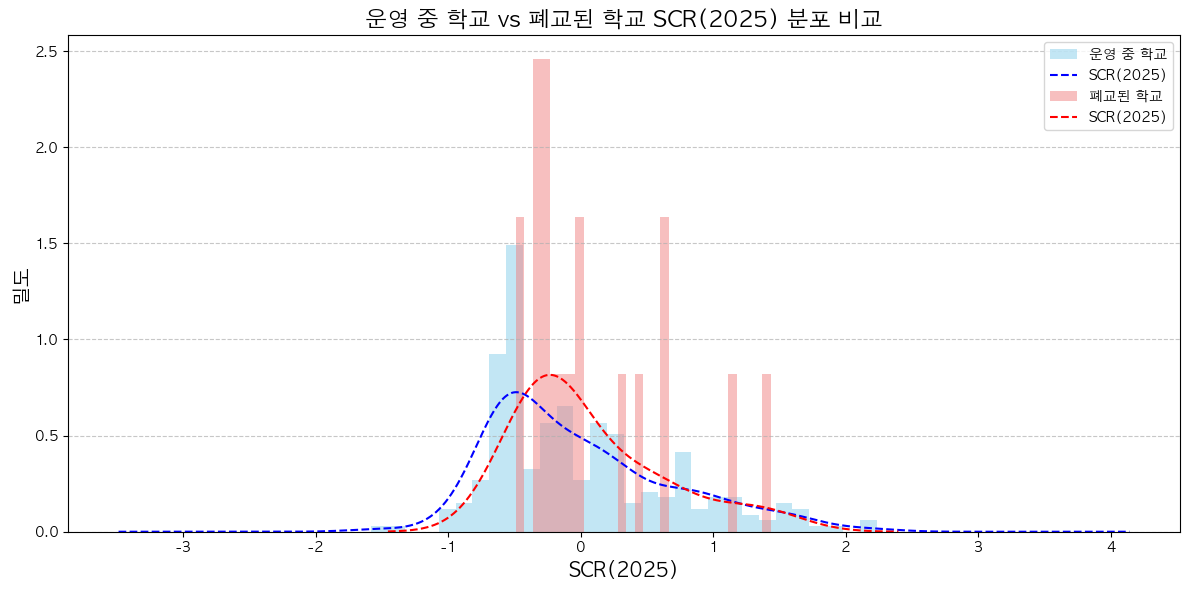

In [1111]:
# 1. 기본 설정
plt.figure(figsize=(12, 6))

# 2. 히스토그램 + 밀도그래프 같이 그리기
# 운영 중인 학교 SCR(2025)
plt.hist(df_scr['SCR(2025)'], bins=30, alpha=0.5, label='운영 중 학교', color='skyblue', density=True)
df_scr['SCR(2025)'].plot(kind='kde', linestyle='--', color='blue')

# 폐교된 학교 SCR(2025)
plt.hist(df_scr_closed['SCR(2025)'], bins=30, alpha=0.5, label='폐교된 학교', color='lightcoral', density=True)
df_scr_closed['SCR(2025)'].plot(kind='kde', linestyle='--', color='red')

# 3. 제목, 라벨, 범례
plt.title('운영 중 학교 vs 폐교된 학교 SCR(2025) 분포 비교', fontsize=16)
plt.xlabel('SCR(2025)', fontsize=14)
plt.ylabel('밀도', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 4. 그래프 출력
plt.tight_layout()
plt.show()

In [1112]:
df_scr

,지역,학교명,S_i(2025),T_i (2025),B_i(2025),D_i(2025),X_i(2025),SCR(2025),폐교위험등급
56,충청북도 옥천군,군남초등학교,0.327439,-0.203591,-1.272219,3.504224,-0.670147,2.233536,위험
64,충청북도 옥천군,장야초등학교,0.284569,-0.197801,-1.272219,3.504224,0.428377,2.119397,위험
255,충청북도 충주시,충주교현초등학교,0.201230,-0.187033,-0.080611,3.671621,-0.152078,1.895325,위험
263,충청북도 충주시,충주예성초등학교,0.265046,0.024621,-0.080611,3.281029,-0.496553,1.740858,위험
65,충청북도 옥천군,죽향초등학교,0.332249,0.137413,-1.272219,2.471943,-0.114104,1.662273,위험
...,...,...,...,...,...,...,...,...,...
216,충청북도 청주시,창리초등학교,-0.545288,0.354187,0.972437,-0.624900,2.964476,-0.955158,안전
212,충청북도 청주시,중앙초등학교,0.054793,0.000744,0.972437,-0.624900,3.661564,-0.964858,안전
187,충청북도 청주시,솔밭초등학교,-0.096198,-0.138618,0.972437,-0.624900,4.160647,-1.029866,안전
204,충청북도 청주시,운동초등학교,-8.852438,-2.311062,0.972437,-0.332942,0.865074,-1.429953,안전


In [1118]:
import numpy as np
import itertools
import pandas as pd
from tqdm import tqdm

# 가중치 후보 리스트 정의
weights_range = np.round(np.arange(-0.5, 0.6, 0.0), 2)

# 0 제외
weights_range = weights_range[weights_range != 0]

# 모든 조합 만들기 (S, B, D, X)
weight_combinations = list(itertools.product(weights_range, repeat=4))

results = []

# ✅ 진행바 추가
for w_s, w_b, w_d, w_x in tqdm(weight_combinations, desc="Grid Search 진행중..."):
    # ✅ 절댓값 합 체크
    if not np.isclose(abs(w_s) + abs(w_b) + abs(w_d) + abs(w_x), 1.0):
        continue  # 절댓값 합이 1이 아니면 건너뛴다
    
    # SCR 계산
    df_scr['SCR_temp'] = (
        df_scr['S_i(2025)'] * w_s +
        df_scr['B_i(2025)'] * w_b +
        df_scr['D_i(2025)'] * w_d +
        df_scr['X_i(2025)'] * w_x
    )
    df_scr_closed['SCR_temp'] = (
        df_scr_closed['S_i'] * w_s +
        df_scr_closed['B_i'] * w_b +
        df_scr_closed['D_i'] * w_d +
        df_scr_closed['X_i'] * w_x
    )

    # 폐교 학교 SCR 분산
    var_closed = df_scr_closed['SCR_temp'].var()
    
    # 운영 중 학교 SCR 분산
    var_open = df_scr['SCR_temp'].var()
    
    # 목표: 폐교 분산 - 운영 분산
    score = var_closed - var_open

    # 결과 저장
    results.append({
        'w_S': w_s, 'w_B': w_b, 'w_D': w_d, 'w_X': w_x,
        '폐교 분산': var_closed,
        '운영 분산': var_open,
        '격차': score
    })

# 결과 정렬
df_result = pd.DataFrame(results).sort_values(by='격차', ascending=False)

Grid Search 진행중...:   0%|          | 164947/141158161 [00:08<2:06:25, 18586.04it/s]


KeyboardInterrupt: 

In [1117]:
df_result

,w_S,w_B,w_D,w_X,폐교 분산,운영 분산,격차
666,0.1,0.3,0.5,-0.1,0.559375,0.247256,0.312119
421,-0.1,-0.3,-0.5,0.1,0.559375,0.247256,0.312119
411,-0.1,-0.4,-0.1,0.4,0.478204,0.171779,0.306425
676,0.1,0.4,0.1,-0.4,0.478204,0.171779,0.306425
682,0.1,0.4,0.4,-0.1,0.517466,0.211412,0.306053
...,...,...,...,...,...,...,...
398,-0.1,-0.5,0.1,-0.3,0.189887,0.502916,-0.313030
564,0.1,-0.4,0.1,-0.4,0.192846,0.511523,-0.318677
523,-0.1,0.4,-0.1,0.4,0.192846,0.511523,-0.318677
550,0.1,-0.5,0.1,-0.3,0.200179,0.529524,-0.329345


In [1067]:
df_scr_closed.to_csv(path + '/SCR_data/SCR_result(폐교).csv', index=False)

In [1068]:
# ✅ 3년 단위 평균 폐교 수 계산

df = df_all_school_info.copy()

# 1. 폐교일자 결측치 제거
df = df.dropna(subset=['폐교일자'])

# 2. 폐교연도 추출
df['폐교연도'] = df['폐교일자'].astype(int) // 10000

# 3. 3년 단위로 그룹핑
df['연도그룹'] = (df['폐교연도'] // 5) * 5

# 4. 그룹별 폐교 학교 수 세기
close_per_group = df.groupby('연도그룹').size()

# 5. 3년 평균 계산
three_year_avg = close_per_group.mean()

# 결과 출력
print(f"3년 단위 평균 폐교 수: {three_year_avg:.2f}개")

3년 단위 평균 폐교 수: 7.25개
